In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%run data_intake.ipynb
import os

In [2]:
aquastat_file_names = [fn for fn in os.listdir("data/") if ".xlsx" in fn]

aquastat_crop_yield = pipeline(aquastat_file_names, "Attainable_yields.csv", "value")

aquastat_crop_yield

,Country,Year,agricultural_value_added_percent_of_gdp,arable_land_area,area_salinized_by_irrigation,dam_capacity,flood_occurence,gdp_per_capita,precipitation_index,total_exploitable_water_resources,total_internal_renewable_water_resource_per_capita,total_population,total_population_with_access_to_safe_drinking_water,total_renewable_water_resources,total_yield
0,Albania,2018,18.429476,611.346,0.000000,4.030000,2.7,5257.650696,1136.0,13.000,9331.399988,2882.740,95.1,30.200,87.14
1,Albania,2017,19.022127,612.000,0.000000,4.030000,2.7,4514.204908,1136.0,13.000,9326.776621,2884.169,95.1,30.200,69.81
2,Albania,2016,19.849993,620.300,0.480000,4.030000,2.7,4109.340457,1136.0,13.000,9319.444935,2886.438,95.1,30.200,68.46
3,Albania,2015,19.780225,615.100,0.960000,4.030000,2.7,3939.413126,1136.0,13.000,9306.306528,2890.513,95.1,30.200,71.04
4,Albania,2014,19.990153,615.600,1.440000,4.030000,2.7,4567.281443,1136.0,13.000,9287.695875,2896.305,95.1,30.200,68.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,Tunisia,2017,9.685052,2607.000,193.294118,2.691378,2.6,3481.203612,326.1,3.625,366.906102,11433.443,97.7,4.615,90.76
108,Tunisia,2016,9.391980,2564.000,186.588235,2.691378,2.6,3697.880363,326.1,3.625,371.109378,11303.945,97.7,4.615,85.10
109,Tunisia,2015,10.282704,2570.000,179.882353,2.691378,2.6,3861.643875,326.1,3.625,375.225325,11179.949,97.7,4.615,83.86
110,Tunisia,2014,9.153284,2588.000,173.176471,2.691378,2.6,4305.543424,326.1,3.625,379.185012,11063.201,97.7,4.615,74.09


In [3]:
# descends the model by a single step
def descend(true_y, pred_y, x, b, alpha=0.01):
    return b - alpha*np.sum(np.subtract(pred_y, true_y)*x)/true_y.size

In [4]:
# Returns a list of predictions for total yield when given X values and b values
def predict(X, b):
    return np.add(np.matmul(X.loc[:, X.columns != 'b0'],b[1:]), b[0])

In [5]:
def mse(true, pred):
    return np.square(np.subtract(true,pred)).mean()

In [106]:
def lin_regression(data, alpha=0.00001, epochs=1000, stats=True, y_col='total_yield', print_=False):
    # generates initial w values
    b = np.zeros(len(data.axes[1]))
    #b = random.rand(len(data.axes[1]))
    
    # removes outcome from data, and inserts a dummy column for w0
    fdata = data.loc[:, data.columns != y_col]
    fdata.insert(0, 'b0', np.ones(len(data)))
    
    if stats:
        mse_list = []
    
    for i in range(epochs):

        pred = predict(fdata, b)
        
        if print_:
            print(b, pred)
        
        # Ends early if the value increases too much
        if math.isnan(pred[0]) or math.isinf(pred[0]):
            print("Value increased to infinity")
            if stats:
                return b, mse_list
            else:
                return b
        
        if stats:
            # Calculates mpe and acc for each epoch
            mse_list.append(mse(data[y_col], pred))
        
        index = 0
        for col in fdata:
            b[index] = descend(data[y_col], pred, fdata[col], b[index], alpha=alpha)
            index +=1
    
    if stats:
        return b, mse_list
    else:
        return b

In [30]:
def pipeline_separate(aquastat_filenames, crop_yield_filename, aquastat_feature):
    """
    Runs the aquastat and crop yield pipeline
    """
    shared_attributes = ["Country", "Year"]
    crop_df = crop_yield_specialized_preprocessing(convert_to_pandas(crop_yield_filename))
    dfs = []
    for fn in aquastat_filenames:
        temp_df = convert_to_pandas(fn)
        strip_temp_df = strip_df(temp_df, shared_attributes + [aquastat_feature])
        renamed_temp_df = aquastat_feature_rename(strip_temp_df, fn, aquastat_feature)
        dfs.append(strip_temp_df)
    
    dfs.append(crop_df)
    
    return dfs

In [31]:
dfs = pipeline_separate(aquastat_file_names, "Attainable_yields.csv", "value")

In [101]:
def test_combos(dfs, yield_df, combination_size=2, alpha_vals=[0.001, 0.0001]):
    results = []
    for size in range(combination_size):
        combs = itertools.combinations(dfs, size)
    
        # Iterates through the list of combination
        for comb in combs:
            data = yield_df
        
            # Merges all the dataframes in the combination into 1
            for df in comb:
                data = data.merge(df, on=["Country", "Year"])
            
            data = data.drop(["Country", "Year"], axis=1)
        
            # Runs linear regression using the given alpha levels
            for alpha in alpha_vals:
                beta, mse_list = lin_regression(data, epochs=1000, alpha=alpha)
                mse_val = mse_list[-1]
            
                # Ensures mse_val is a number
                if math.isnan(mse_val) or math.isinf(mse_val):
                    mse_val = 99999999
                
                results.append((mse_val, beta, alpha, data.axes[1]))
            
            
    return results

In [102]:
combos = test_combos(dfs[:-1], dfs[-1], combination_size=3, alpha_vals=[0.001, 0.0001, 0.00001])

C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity
Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


C:\Users\rmons\School\Anaconda\envs\ml\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)


Value increased to infinity


In [105]:
valid_combos = [combo for combo in combos if combo[0] < 99999999]
valid_combos

[(3054.4387665004588,
  array([45.3848944]),
  0.001,
  Index(['total_yield'], dtype='object')),
 (6575.348571806306,
  array([6.83080472]),
  0.0001,
  Index(['total_yield'], dtype='object')),
 (7406.519053203893,
  array([0.71419615]),
  1e-05,
  Index(['total_yield'], dtype='object')),
 (3278.119111582906,
  array([27.57768629,  1.52490335]),
  0.001,
  Index(['total_yield', 'agricultural_value_added_percent_of_gdp'], dtype='object')),
 (4591.935393496022,
  array([3.43819034, 2.39669109]),
  0.0001,
  Index(['total_yield', 'agricultural_value_added_percent_of_gdp'], dtype='object')),
 (4793.404671043973,
  array([0.43118005, 2.46670393]),
  1e-05,
  Index(['total_yield', 'agricultural_value_added_percent_of_gdp'], dtype='object')),
 (5975.200366754301,
  array([6.34644768, 0.28569195]),
  0.0001,
  Index(['total_yield', 'dam_capacity'], dtype='object')),
 (6693.109138373888,
  array([0.66150025, 0.30166047]),
  1e-05,
  Index(['total_yield', 'dam_capacity'], dtype='object')),
 (218

In [110]:
final_df = dfs[-1].merge(dfs[0], on=["Country", "Year"]).merge(dfs[4], on=["Country", "Year"])

In [133]:
# Runs the linear regression with only agricultural_value_added_percent_of_gdp and flood_occurence 
beta, mse_list = lin_regression(final_df.drop(["Country", "Year"], axis=1), epochs=1000, alpha=0.01)

In [134]:

pred = predict(final_df.drop(["Country", "Year", "total_yield"], axis=1), beta)
true = final_df["total_yield"]

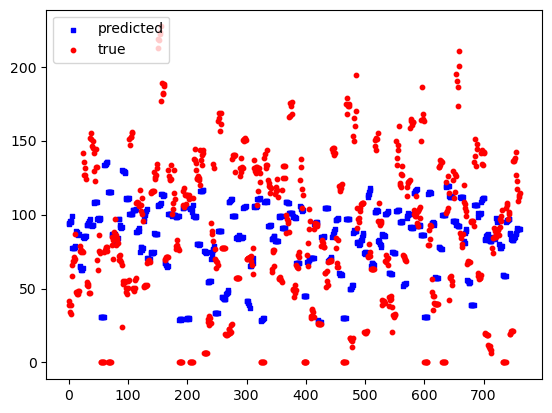

In [136]:
# Plots something for sure
x = range(len(pred))
y = range(100,200)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, pred, s=10, c='b', marker="s", label='predicted')
ax1.scatter(x, true, s=10, c='r', marker="o", label='true')
plt.legend(loc='upper left')
plt.show()